In [1]:
import plaidml
import plaidml.exec
from plaidml.edsl import *
import drawSvg as draw


def edsl_program(X, Y):
    I, J, K = TensorDims(3)
    i, j, k = TensorIndexes(3)
    X.bind_dims(I, K)
    Y.bind_dims(K, J)
    R = TensorOutput(I, J)
    R[i, j] += X[i, k] * Y[k, j]
    return R

In [2]:
A = Tensor(LogicalShape(plaidml.DType.FLOAT32, [3, 3]))
B = Tensor(LogicalShape(plaidml.DType.FLOAT32, [3, 3]))
O = edsl_program(A, B)

In [3]:
program = Program('edsl_program', [O])
#print(str(program))

#map0 = affine_map<(d0, d1, d2) -> (d0, d1)>
#map1 = affine_map<(d0, d1, d2) -> (d0, d2)>
#map2 = affine_map<(d0, d1, d2) -> (d2, d1)>


!f32 = type tensor<!eltwise.f32>
module {
  func @edsl_program(%arg0: tensor<3x3x!eltwise.f32>, %arg1: tensor<3x3x!eltwise.f32>) -> tensor<3x3x!eltwise.f32> {
    %cst = "eltwise.sconst"() {value = 0.000000e+00 : f64} : () -> !f32
    %0 = tile.cion add, mul, %cst, %arg1, %arg0 {sink = #map0, srcs = [#map1, #map2]} : !f32, tensor<3x3x!eltwise.f32>, tensor<3x3x!eltwise.f32> -> tensor<3x3x!eltwise.f32>
    return %0 : tensor<3x3x!eltwise.f32>
  }
}


In [1]:
output_dims = program.outputs[0].shape.int_dims
#print(output_dims)

NameError: name 'program' is not defined

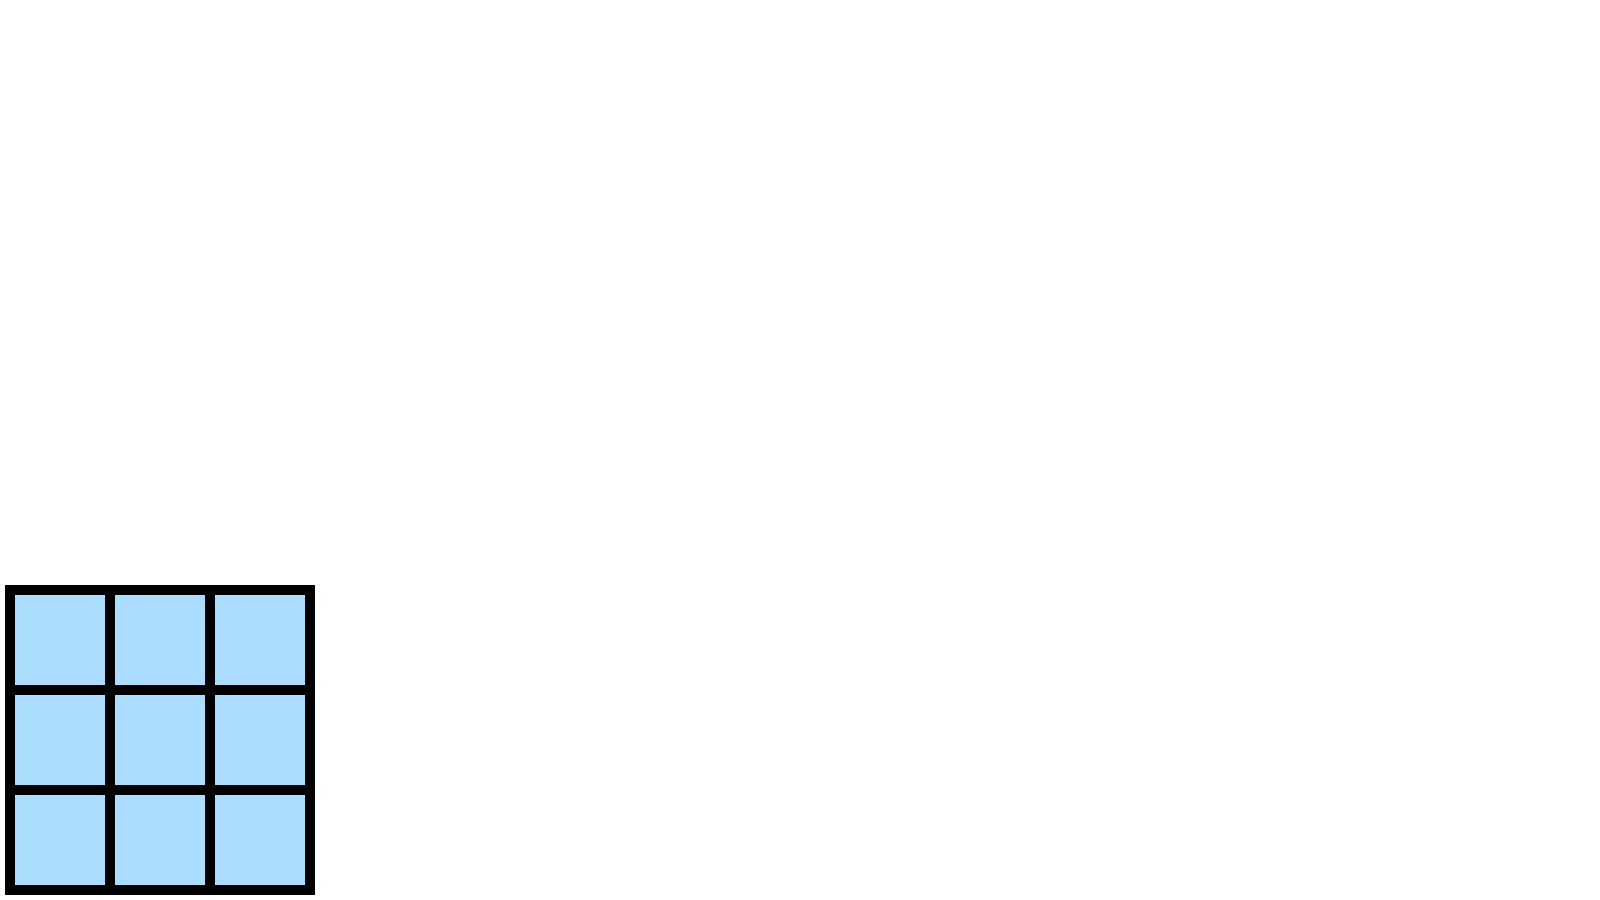

In [5]:
grid_width = 10
d = draw.Drawing(1600, 900, origin = (0, 0))
for x in range(output_dims[0]):
    for y in range(output_dims[1]):
        d.append(draw.Rectangle(100 * x + grid_width, 100 * y + grid_width, 
                                100, 100, 
                        stroke_width = grid_width, stroke = 'black',
                        fill = '#aaddff'))
d.rasterize()

In [7]:
binder = plaidml.exec.Binder(program)
executable = binder.compile()
executable.run()